## CA-2

In [1]:
# importing libraries
import pandas as pd
import time
import re
import string

In [2]:
# Helper functions

def time_elapsed_start():
    return time.time()

def time_elapsed_stop(start):
    sec = time.time() - start
    min = sec/60
    hour = min/60
    print(f"Execution took {sec} seconds - ({min} minutes), ({hour} hours)")

In [3]:
# loading data
ROWS_TO_READ = 200000
df = pd.read_csv('quora_questions.csv', nrows=ROWS_TO_READ)

In [4]:
df.sample(5)

,question
114733,I am a future European student that wants to a...
172622,Is India changing?
173428,What is the detailed difference between electr...
19786,Who designed BHIM app?
193298,How do you became a jerk?


In [5]:
for i in range(0, 10):
    print(df['question'][i])

What is the step by step guide to invest in share market in india?
What is the story of Kohinoor (Koh-i-Noor) Diamond?
How can I increase the speed of my internet connection while using a VPN?
Why am I mentally very lonely? How can I solve it?
Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Should I buy tiago?
How can I be a good geologist?
When do you use ã‚· instead of ã—?
Motorola (company): Can I hack my Charter Motorolla DCX3400?


In [6]:
# dataframe size|
print(f"Dataframe size: {df.size}")

Dataframe size: 200000


### Pre-processing

We are considering that a word should come in atleast 2 documents and should not come in more than 90% of the documents.

In [7]:
def clean(question):
    question = question.lower()
    question = re.sub(r'[%s]' % re.escape(string.punctuation), '', question)
    question = re.sub(r'[^A-Za-z0-9]+ ', '', question)
    return question

df_clean = pd.DataFrame(df.question.apply(lambda x: clean(x)))

In [8]:
for i in range(0, 10):
    print(df_clean['question'][i])

what is the step by step guide to invest in share market in india
what is the story of kohinoor kohinoor diamond
how can i increase the speed of my internet connection while using a vpn
why am i mentally very lonely how can i solve it
which one dissolve in water quikly sugar salt methane and carbon di oxide
astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
should i buy tiago
how can i be a good geologist
when do you useinstead of ã—
motorola company can i hack my charter motorolla dcx3400


In [9]:
df_clean.sample(5)

,question
45798,why am i losing interest in everything
5034,does the tv show preacher have any nudity
23834,whats are the meaning of life
145527,how can i stop my hair fall
93314,how were new horizons rosetta mars missions an...


In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [11]:
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)
    
df_clean["question_clean"] =  df_clean.apply(lambda x: lemmatizer(x['question']), axis=1)

In [14]:
df_clean['question_clean'] = df_clean['question_clean'].str.replace('-PRON-', '')

In [15]:
df_clean.sample(5)

,question,question_clean
196368,how do infrasonic and ultrasonic sound waves d...,how do infrasonic and ultrasonic sound wave di...
184708,what would happen if porn suddenly vanished,what would happen if porn suddenly vanish
119926,where is the best spoken english classes in pune,where be the good spoken english class in pune
163801,how much should i pay a college intern,how much should i pay a college intern
70302,what are tracer rounds are they legal for the ...,what be tracer round be legal for the public ...


In [16]:
for i in range(0, 10):
    print(df_clean['question_clean'][i])

what be the step by step guide to invest in share market in india
what be the story of kohinoor kohinoor diamond
how can i increase the speed of  internet connection while use a vpn
why be i mentally very lonely how can i solve 
which one dissolve in water quikly sugar salt methane and carbon di oxide
astrology i be a capricorn sun cap moon and cap risingwhat do that say about 
should i buy tiago
how can i be a good geologist
when do  useinstead of ã—
motorola company can i hack  charter motorolla dcx3400


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')

In [34]:
start = time_elapsed_start()
term_matrix = count_vectorizer.fit_transform(df_clean['question_clean'])
time_elapsed_stop(start)

Execution took 3.8101696968078613 seconds - (0.06350282828013103 minutes), (0.001058380471335517 hours)


In [35]:
term_matrix

<200000x12305 sparse matrix of type '<class 'numpy.int64'>'
	with 899423 stored elements in Compressed Sparse Row format>

The vector has taken 27,884 words in the vocabulary from 2,00,000 questions(rows).

# Applying LDA

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
lda = LatentDirichletAllocation(n_components=14, random_state=3)

In [36]:
start = time_elapsed_start()
lda.fit(term_matrix)
time_elapsed_stop(start)

Execution took 357.62371921539307 seconds - (5.960395320256551 minutes), (0.09933992200427585 hours)


Checking log likelihood, perplexity

In [37]:
start = time_elapsed_start()
log_likelihood = lda.score(term_matrix)
perplexity = lda.perplexity(term_matrix)
time_elapsed_stop(start)

Execution took 74.32639718055725 seconds - (1.2387732863426208 minutes), (0.02064622143904368 hours)


In [38]:
print(f"Log likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

Log likelihood: -7269604.801724052
Perplexity: 2538.1978778472244


In [39]:
# Creating a metrics dataframe for comparison later
lda_metrics_df = pd.DataFrame([[log_likelihood, perplexity, 13, 0.7]], columns=['log_likelihood', 'perplexity', 'n_components', 'learning_decay'])

In [40]:
lda_metrics_df

,log_likelihood,perplexity,n_components,learning_decay
0,-7.269605e+06,2538.197878,13,0.7


## Applying GridSearch for finding out best parameters for LDA

In [ ]:
# importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

In [ ]:
# creating parameters for LDA
params = {'n_components': [5, 7, 9, 10, 12, 14], 'learning_decay': [.3, .5, .7, .9]}

In [ ]:
# Initializing evaluate LDA and passing parameters to it
eval_lda = LatentDirichletAllocation()
eval_lda = GridSearchCV(eval_lda, param_grid=params)

In [ ]:
# Fitting the model
# this will search for optimal parameters
# Note: this process consumes a significant amount of time and resources
start = time_elapsed_start()
eval_lda.fit(term_matrix)
time_elapsed_stop(start)

In [ ]:
# Best Model which gave highest score 
best_lda_model = lda_comparison.best_estimator_

# Model Parameters is used to store a list of parameter settings dicts for all the parameter candidates
print("Best Model's Params: ", lda_comparison.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_comparison.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix))

In [ ]:
lda = LatentDirichletAllocation(n_components=12, random_state=3)

In [ ]:
start = time_elapsed_start()
lda.fit(term_matrix)
time_elapsed_stop(start)

In [ ]:
start = time_elapsed_start()
log_likelihood = lda.score(term_matrix)
perplexity = lda.perplexity(term_matrix)
time_elapsed_stop(start)

In [ ]:
print(f"Log likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

In [ ]:
# storing metrics in metrics dataframe
lda_metrics_df.loc[-1] = [log_likelihood, perplexity, 12, 0.7]
lda_metrics_df.index = lda_metrics_df.index + 1
lda_metrics_df = lda_metrics_df.sort_index()

In [ ]:
lda_metrics_df

## Exploring topics and their words

We have 27,885 words in the vocabulary. 

In [41]:
lda.components_.shape

(14, 12305)

10 topics with 27,885 words

Exploring a random topic

In [42]:
random_topic = lda.components_[6]

In [43]:
import matplotlib.pyplot as plt

In [44]:
def show_chart(words, count, chart_title):
    d = pd.DataFrame({"Words": words, "Count": count})
    # Sort the dataframe by largest count
    d = d.sort_values(by=["Count"], ascending=False)
    ax = d.plot.bar(y="Count", x="Words", title=chart_title, figsize=(15, 10), legend=True, fontsize=12, rot=1)
    ax.set_xlabel("Frequent words", fontsize=12)
    ax.set_ylabel("Word count", fontsize=12)

affect
election
government
rs
rupee
ban
black
1000
500
win
long
note
mean
indian
india


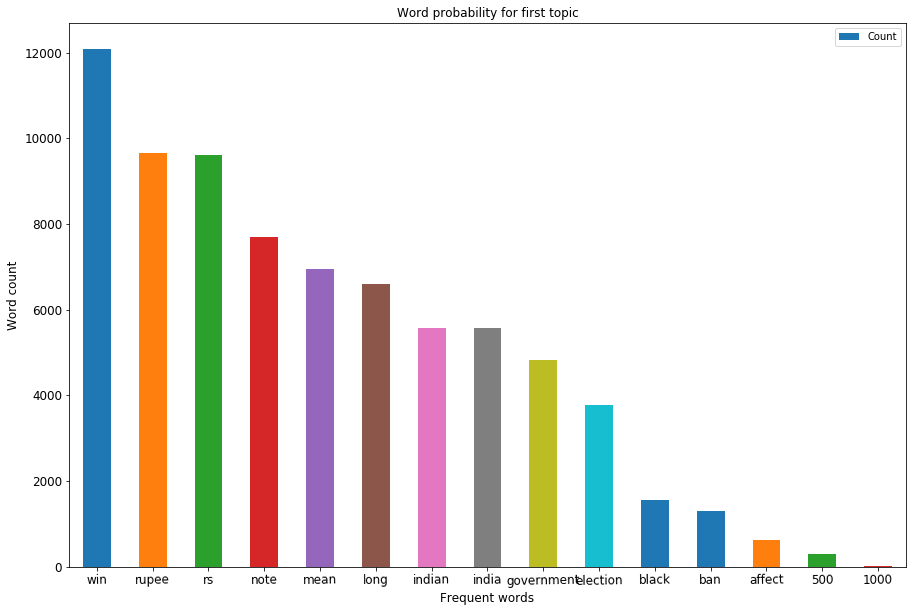

In [45]:
word_list = []
probability_list = []

for index in random_topic.argsort()[-15:]:
    frequent_word = count_vectorizer.get_feature_names()[index]
    print(frequent_word, sep=" ")
    word_list.append(frequent_word)
    probability_list.append(index)
    
show_chart(word_list, probability_list, "Word probability for first topic")

In [46]:
word_list = []
probability_list = []

top_number = 25
count = 0
for probability_number in lda.components_:
    text_message = f"Top words for topic {count} are : "
    print(text_message)    
    for number in probability_number.argsort()[-top_number:]:
        print([count_vectorizer.get_feature_names()[number]], end= "")
    print("\n")  
    count += 1

Top words for topic 0 are : 
['credit']['happen']['city']['moment']['medium']['eye']['force']['battle']['solve']['drive']['death']['body']['deal']['change']['compare']['god']['social']['law']['problem']['earth']['human']['card']['number']['use']['life']

Top words for topic 1 are : 
['interview']['2017']['job']['advantage']['develop']['laptop']['make']['new']['fall']['china']['java']['tip']['speak']['english']['buy']['country']['process']['song']['write']['learn']['read']['love']['book']['way']['good']

Top words for topic 2 are : 
['week']['fast']['invest']['gain']['fat']['period']['sentence']['startup']['know']['employee']['software']['job']['month']['word']['engineer']['use']['car']['good']['company']['new']['thing']['weight']['lose']['day']['work']

Top words for topic 3 are : 
['sydney']['company']['suicide']['temperature']['make']['quality']['design']['project']['compare']['study']['use']['online']['drink']['buy']['sell']['type']['india']['product']['average']['hair']['cost']['se